In [5]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as np
from jax.numpy import array as arr
from jax import lax, random
from jax.scipy.special import expit as logistic

import numpyro as pn
from numpyro import sample
from numpyro import deterministic
import numpyro.distributions as dist
from numpyro.distributions import Normal as Norm
from numpyro.distributions import Exponential as Ex
from numpyro.distributions import Poisson as Pois
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import print_summary

import warnings
pn.set_platform("cpu")
pn.set_host_device_count(4)

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(category.__name__, message)
%watermark -n -u -v -iv -w

Last updated: Thu Sep 08 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

numpyro   : 0.10.1
pandas    : 1.4.4
arviz     : 0.12.1
jax       : 0.3.17
sys       : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:38:29) [Clang 13.0.1 ]
matplotlib: 3.5.3

Watermark: 2.3.1



In [3]:
def z(x):
    return (x - x.mean()) / x.std()
    
## for jax's RNG
def key_gen(seed = random.PRNGKey(8927)):
    def key():
        nonlocal seed
        seed, new_key = random.split(seed)
        return new_key
    return key

key = key_gen()

In [4]:
## ch 15.1 incorporating known measurement error

d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
## standardize
d['D'] = z(d['Divorce'])
d['D_sd'] = d['Divorce SE'] / d['Divorce'].std()
d['M'] = z(d['Marriage'])
d['M_sd'] = d['Marriage SE'] / d['Marriage'].std()
d['A'] = z(d['MedianAgeMarriage'])
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,D,D_sd,M,M_sd,A
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,1.654205,0.433872,0.022644,0.334395,-0.606290
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,1.544364,1.125870,1.549802,0.771478,-0.686699
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,0.610716,0.406412,0.048974,0.258037,-0.204241
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,2.093569,0.670030,1.655123,0.447615,-1.410387
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,-0.927058,0.131809,-0.266989,0.102688,0.599857


In [ ]:
def model1(A, M, M_sd, D_sd, D=None): 
    a = sample("a", Norm(0, 0.2))
    bA = sample("bA", Norm(0, 0.5))
    bM = sample("bM", Norm(0, 0.5))
    s = sample("s", Ex(1))
    #to incorporate M_sd also:
    #M_true = sample("M_true", Norm(0,1), sample_shape=M.shape) ## shape _i (each row); Norm 0,1 because std
    #sample("M_obs", Norm(M_true, M_sd), obs=M)
    ##otherwise:
    M_true = M
    mu = deterministic("mu", a + bA*A + bM*M_true) ## mu_i, shape of A or M_true
    D_true = sample("D_true", Norm(mu, s)) ## _i, shape of mu
    sample("D_obs", Norm(D_true, D_sd), obs=D)

m1 = MCMC(NUTS(model1), num_warmup=500, num_samples=500, num_chains=4)
m1.run(key(), d['A'].values, d['M'].values, d['M_sd'].values, d['D_sd'].values, d['D'].values)

In [22]:
az.summary(m1, var_names=['a', 'bA', 'bM', 's'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.055,0.094,-0.231,0.115,0.002,0.002,2419.0,1650.0,1.0
bA,-0.612,0.161,-0.893,-0.288,0.004,0.003,1855.0,1658.0,1.0
bM,0.055,0.171,-0.257,0.369,0.004,0.003,1824.0,1333.0,1.0
s,0.584,0.111,0.388,0.794,0.004,0.003,740.0,695.0,1.0


In [23]:
post1 = m1.get_samples()
## for predictive A -> D, set M to mean (0)
post_pred1 = Predictive(model1, post1)(key(), 
 d['A'].values, np.zeros(len(d['M'])), np.zeros(len(d['M_sd'])), d['D_sd'].values, d['D'].values)

<AxesSubplot:>

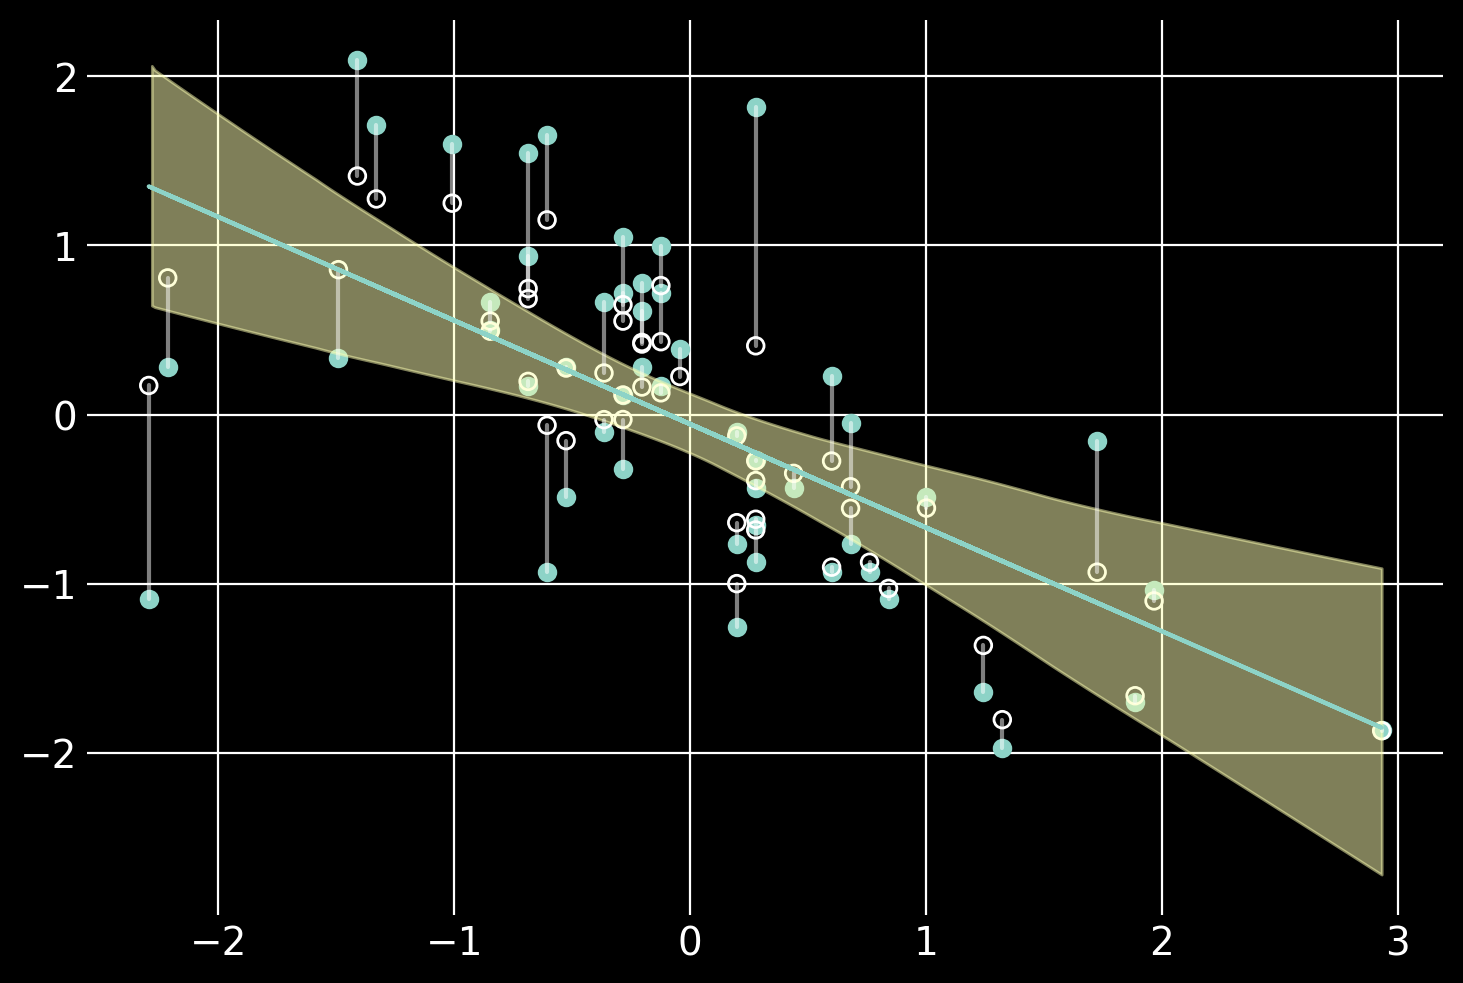

In [24]:
_, ax = plt.subplots()
ax.scatter(d['A'], d['D'])
ax.scatter(d['A'], post1['D_true'].mean(0), color="none", edgecolor="w")
## lines
ax.plot([d['A'],d['A']], [d['D'],post1['D_true'].mean(0)], "w-", alpha=0.5)
## mu is the linear model
ax.plot(d['A'], post_pred1['mu'].mean(0))
az.plot_hdi(d['A'], post_pred1['mu'])

#### 15.3

$N \sim poisson(\lambda)$ ; N = notes sung  
$log(\lambda) = \alpha + \beta C$ ; C = presence/absence of cat  
$ C \sim bern(k) $ ; cat is present with prob k  
$ R_c \sim bern(r) $ ; cat data is missing with prob r

In [67]:
n = 100
a_true = 3.0# 5.0
b_true = -2.0 #-3.0
k_true = 0.5
r = 0.2
C = 1 * random.bernoulli(key(), k_true, (n,)) ##random.bernoulli returns bools
notes_obs = random.poisson(key(), np.exp(a_true + b_true*C))
R_c = random.bernoulli(key(), r, (n,))
C_obs = C.at[R_c == True].set(-9)


In [ ]:
## pre-compute missing/not-missing
##  jax doesn't allow arrays of undetermined size inside the model fn
dat = {'notes_Cobs': notes_obs[C_obs != -9], 'notes_Cmiss': notes_obs[C_obs == -9], 'Cobs': C_obs[C_obs != -9],}

def model8(notes_Cobs, notes_Cmiss, Cobs):
    a = sample("a", Norm(0,5))
    b = sample("b", Norm(0,5))
    k = sample("k", dist.Beta(2,2)) ## true k unknown

    ## manually add the log-likelihood for cat unknown cases using numpyro.factor()
    ## p = p(cat)p(notes|cat) + p(no cat)p(notes|no cat)
    logp_N_cat = Pois(np.exp(a+b)).log_prob(notes_Cmiss)
    logp_N_nocat = Pois(np.exp(a)).log_prob(notes_Cmiss)
    logpCpNcat = np.log(k) + logp_N_cat
    logpCpNno = np.log(1-k) + logp_N_nocat
    total_logp = np.logaddexp(logpCpNcat, logpCpNno)
    pn.factor("notes|RC==1", total_logp)

    ## true k unknown, need to estimate
    #cat_RC0 = sample("cat|RC==0", dist.Bernoulli(k), obs=Cobs)
    sample("cat|RC==0", dist.Bernoulli(k), obs=Cobs)
    ## likelihood when cat data available
    #mu = deterministic("mu", np.exp(a + b*cat_RC0))
    mu = deterministic("mu", np.exp(a + b*Cobs))   ## same
    sample("notes|RC==0", Pois(mu), obs=notes_Cobs)

m8 = MCMC(NUTS(model8), num_warmup=500, num_samples=500, num_chains=4)
m8.run(key(), **dat)



In [73]:
m8.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.03      0.03      3.03      2.98      3.08   1702.54      1.00
         b     -2.12      0.10     -2.12     -2.28     -1.97   1563.19      1.00
         k      0.49      0.05      0.49      0.40      0.56   2031.89      1.00

Number of divergences: 0


In [74]:
## reconstruct post prob for unknown cats
def model9(notes_Cobs, notes_Cmiss, Cobs):
    a = sample("a", Norm(0,5))
    b = sample("b", Norm(0,5))
    k = sample("k", dist.Beta(2,2)) ## true k unknown

    logp_N_cat = Pois(np.exp(a+b)).log_prob(notes_Cmiss)
    logp_N_nocat = Pois(np.exp(a)).log_prob(notes_Cmiss)
    logpCpNcat = np.log(k) + logp_N_cat
    logpCpNno = np.log(1-k) + logp_N_nocat
    total_logp = np.logaddexp(logpCpNcat, logpCpNno)
    pn.factor("notes|RC==1", total_logp)

    sample("cat|RC==0", dist.Bernoulli(k), obs=Cobs)
    mu = deterministic("mu", np.exp(a + b*Cobs))  
    sample("notes|RC==0", Pois(mu), obs=notes_Cobs)

    ## p(c=1|N) = p(N|c=1)p(c=1) / p(N)
    ##    p(N) = p(n|c=1)p(c=1) + p(n|c=0)p(c=0)
    logpC1 = deterministic("logpC1", np.log(k) + Pois(np.exp(a+b)).log_prob(notes_obs))
    logpC0 = deterministic("logpC0", np.log(1-k) + Pois(np.exp(a)).log_prob(notes_obs))
    deterministic("pC1", np.exp(logpC1) / (np.exp(logpC1) + np.exp(logpC0)))

m9 = MCMC(NUTS(model9), num_warmup=500, num_samples=500, num_chains=4)
m9.run(key(), **dat)


Compiling.. :   0%|          | 0/1000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 1000/1000 [00:02<00:00, 344.39it/s]


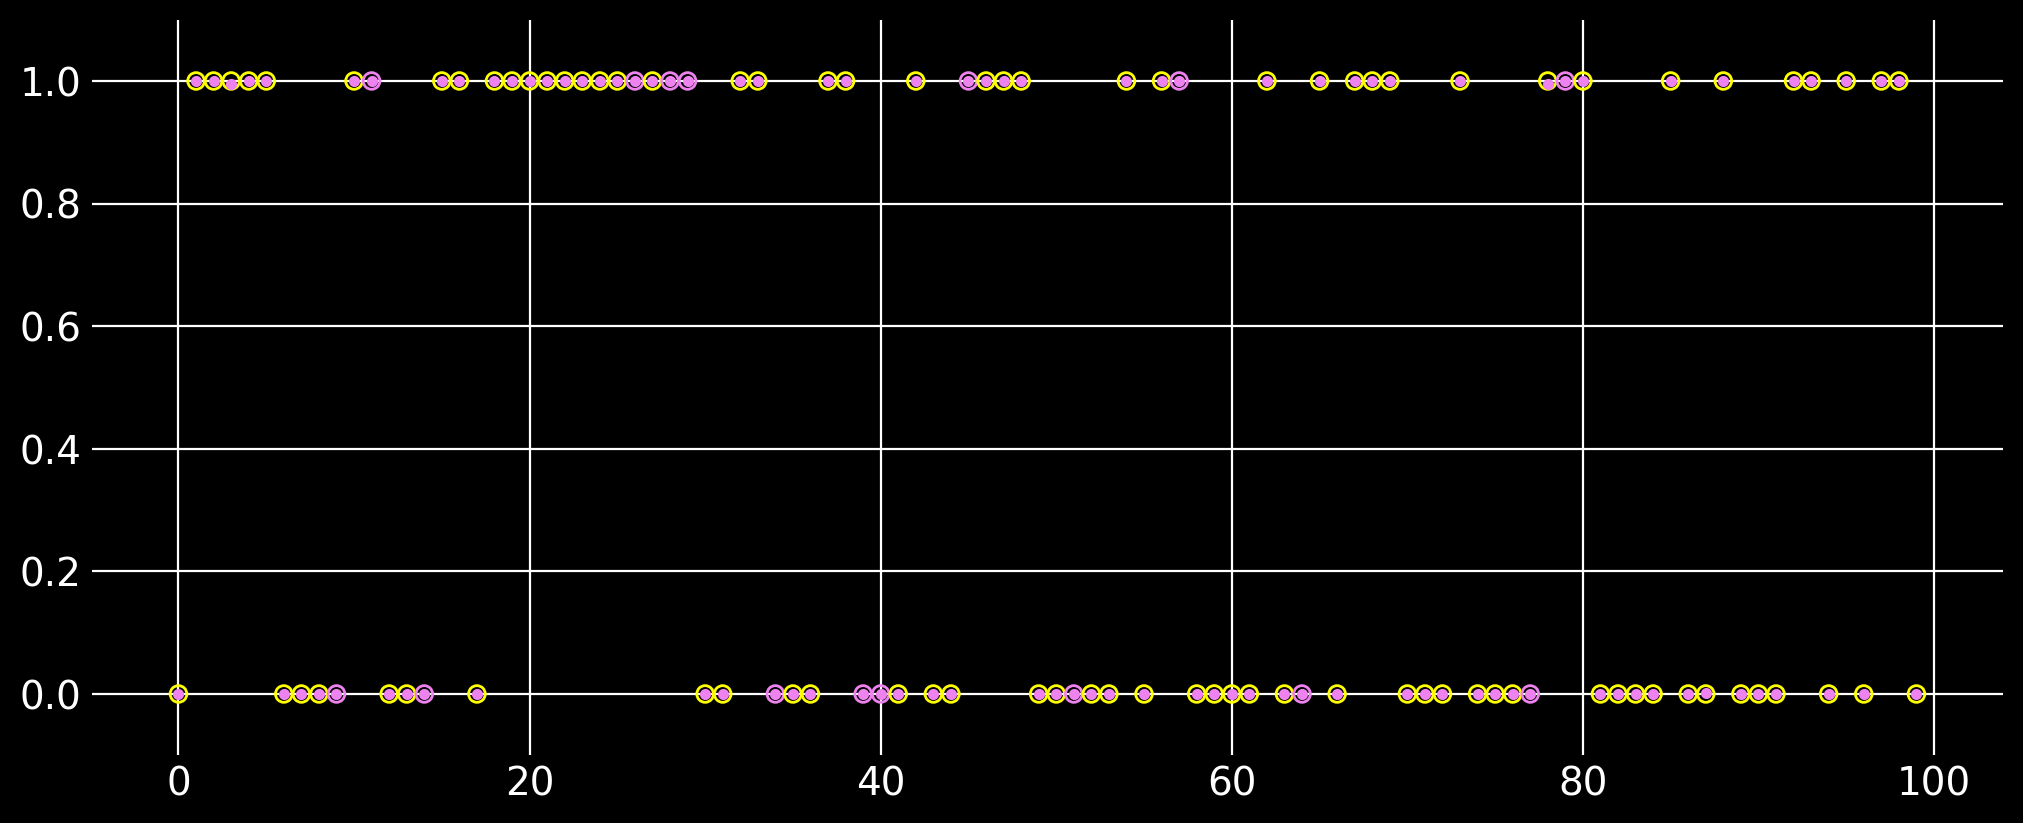

In [77]:
_, ax = plt.subplots(figsize=[10,4])
ax.set_ylim(-0.1,1.1)
ax.scatter(np.arange(n), C, color="none", edgecolor=["violet" if x==-9 else "yellow" for x in C_obs])
ax.scatter(np.arange(n) , m9.get_samples()['pC1'].mean(0), marker='.', color="violet")